import libraries

In [31]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
from ast import literal_eval
pd.set_option('max_columns', None)

Setup pySpark

Load dataset (by batch)<br>
<br>
Original dataset

In [2]:
data = pd.read_csv('ga-customer-revenue-prediction/train.csv',dtype={'fullVisitorId': object})

'''
df = pd.read_csv('./downloads/gstore/train_v2.csv', dtype={'fullVisitorId': object}, 
nrows=100001, skiprows=range(1, 100000))

'''

"\ndf = pd.read_csv('./downloads/gstore/train_v2.csv', dtype={'fullVisitorId': object}, \nnrows=100001, skiprows=range(1, 100000))\n\n"

In [3]:
data.shape

(903653, 12)

In [4]:
data.columns

Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

In [5]:
data.head(2)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147


In [28]:
def load_df(file_name = 'train.csv', nrows = None):
    """Read csv and convert json columns."""
    
    USE_COLUMNS = [
        'channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
        'socialEngagementType', 'totals', 'trafficSource', 'visitId',
        'visitNumber', 'visitStartTime', 'sessionId',
    ]

    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv('ga-customer-revenue-prediction/{}'.format(file_name),
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, nrows=nrows, usecols=USE_COLUMNS)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
    return df
    

In [29]:
sample = load_df()

In [32]:
sample.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_isTrueDirect,trafficSource_referralPath,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adContent,trafficSource_campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

understanding the data features (distribution)<br>
1) User level<br>
2) Transaction level

In [39]:
sample['channelGrouping'].value_counts()

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64

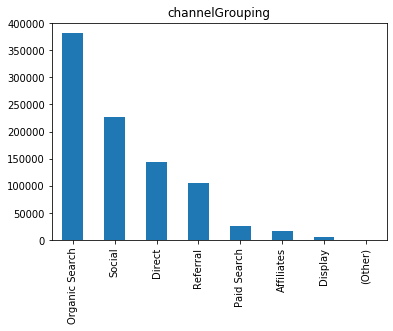

In [95]:
sample['channelGrouping'].value_counts().plot.bar(title='channelGrouping')

In [40]:
# each 'fullVisitorId' represents a user
sample['fullVisitorId'].value_counts()

1957458976293878100    278
0824839726118485274    255
3608475193341679870    201
1856749147915772585    199
3269834865385146569    155
                      ... 
4169845887290339071      1
8500258977783435685      1
6244609149629640541      1
5116382033012344403      1
888237465269618900       1
Name: fullVisitorId, Length: 714167, dtype: int64

In [42]:
sample['visitNumber'].value_counts() #what does 'visitNumber' mean?

1      703060
2       92548
3       35843
4       19157
5       11615
        ...  
306         1
349         1
350         1
351         1
395         1
Name: visitNumber, Length: 384, dtype: int64

In [43]:
sample['device_browser'].value_counts()

Chrome                                         620364
Safari                                         182245
Firefox                                         37069
Internet Explorer                               19375
Edge                                            10205
Android Webview                                  7865
Safari (in-app)                                  6850
Opera Mini                                       6139
Opera                                            5643
UC Browser                                       2427
YaBrowser                                        2096
Coc Coc                                           727
Amazon Silk                                       561
Android Browser                                   553
Mozilla Compatible Agent                          374
MRCHROME                                          263
Maxthon                                           246
BlackBerry                                        184
Nintendo Browser            

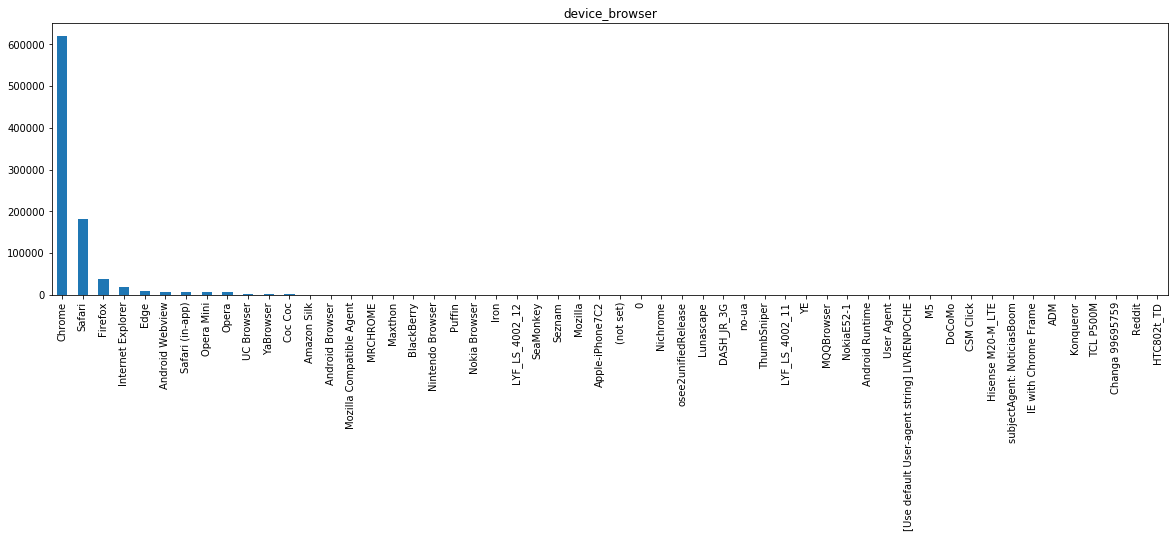

In [98]:
sample['device_browser'].value_counts().plot.bar(title='device_browser',figsize=(20,5))

In [46]:
sample['device_operatingSystem'].value_counts()

Windows          350072
Macintosh        253938
Android          123892
iOS              107665
Linux             35034
Chrome OS         26337
(not set)          4695
Windows Phone      1216
Samsung             280
BlackBerry          218
Nintendo Wii        100
Firefox OS           89
Xbox                 66
Nintendo WiiU        35
FreeBSD               9
Nokia                 2
OpenBSD               2
SunOS                 1
Nintendo 3DS          1
NTT DoCoMo            1
Name: device_operatingSystem, dtype: int64

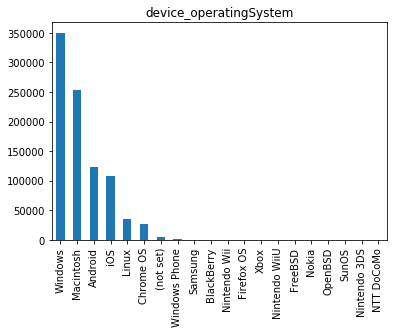

In [100]:
sample['device_operatingSystem'].value_counts().plot.bar(title='device_operatingSystem')

In [47]:
sample['device_isMobile'].value_counts()

False    664530
True     239123
Name: device_isMobile, dtype: int64

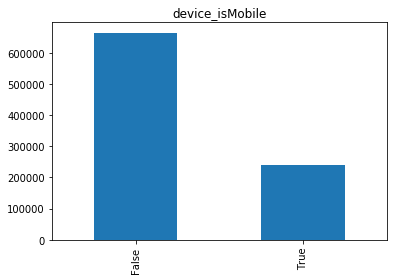

In [101]:
sample['device_isMobile'].value_counts().plot.bar(title='device_isMobile')

In [57]:
sample['device_deviceCategory'].value_counts()

desktop    664479
mobile     208725
tablet      30449
Name: device_deviceCategory, dtype: int64

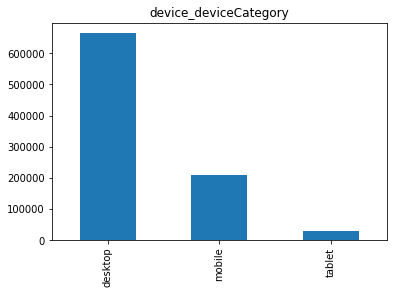

In [102]:
sample['device_deviceCategory'].value_counts().plot.bar(title='device_deviceCategory')

In [58]:
sample['geoNetwork_continent'].value_counts()

Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: geoNetwork_continent, dtype: int64

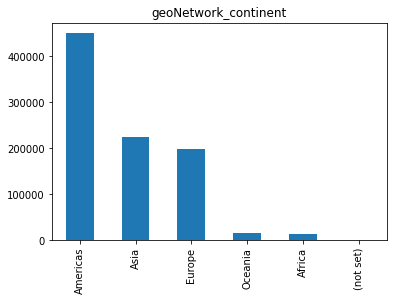

In [103]:
sample['geoNetwork_continent'].value_counts().plot.bar(title='geoNetwork_continent')

In [59]:
sample['geoNetwork_subContinent'].value_counts()

Northern America      390657
Southeast Asia         77800
Southern Asia          59321
Western Europe         59114
Northern Europe        58168
Eastern Asia           46919
Eastern Europe         45249
South America          41731
Western Asia           38443
Southern Europe        35780
Central America        15583
Australasia            14893
Northern Africa         7683
Western Africa          2573
Caribbean               2406
Southern Africa         2169
Eastern Africa          1927
(not set)               1468
Central Asia            1215
Middle Africa            393
Melanesia                 81
Micronesian Region        55
Polynesia                 25
Name: geoNetwork_subContinent, dtype: int64

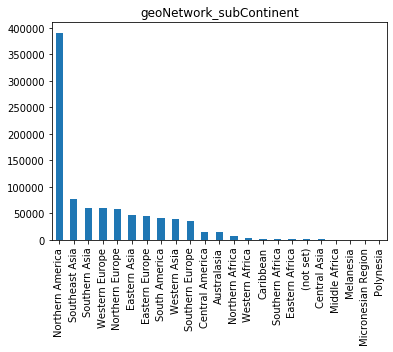

In [104]:
sample['geoNetwork_subContinent'].value_counts().plot.bar(title='geoNetwork_subContinent')

In [60]:
sample['geoNetwork_country'].value_counts()

United States          364744
India                   51140
United Kingdom          37393
Canada                  25869
Vietnam                 24598
                        ...  
Samoa                       1
Norfolk Island              1
St. Martin                  1
American Samoa              1
São Tomé & Príncipe         1
Name: geoNetwork_country, Length: 222, dtype: int64

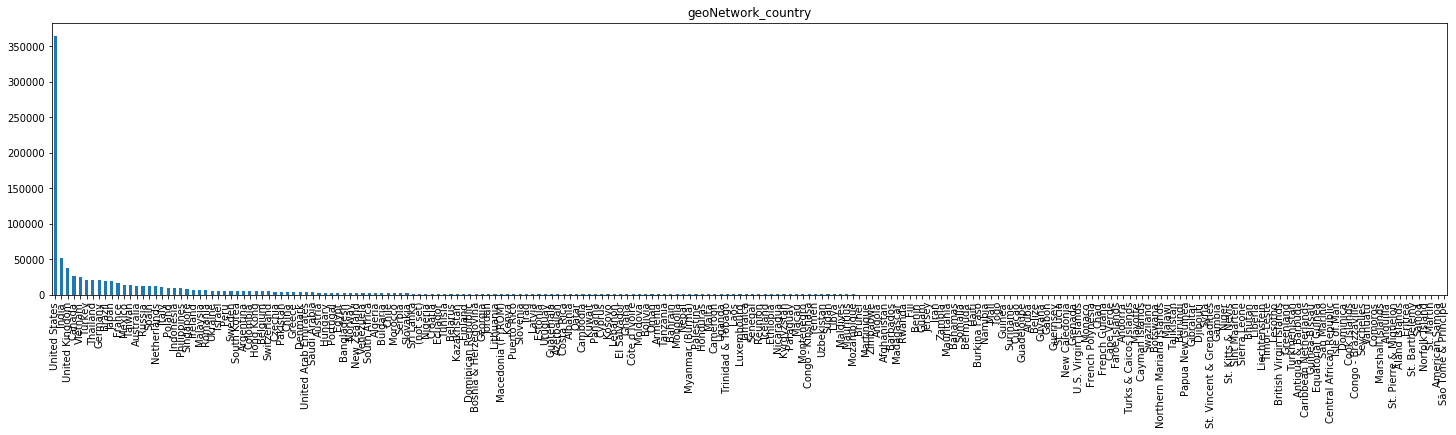

In [107]:
sample['geoNetwork_country'].value_counts().plot.bar(title='geoNetwork_country',figsize=(25,5))

In [109]:
sample['geoNetwork_region'].value_counts()

not available in demo dataset    508229
California                       107495
(not set)                         27827
New York                          26433
England                           13198
                                  ...  
Abruzzo                               6
Ha Tinh Province                      6
San Salvador Department               5
Kumamoto Prefecture                   5
Montana                               3
Name: geoNetwork_region, Length: 376, dtype: int64

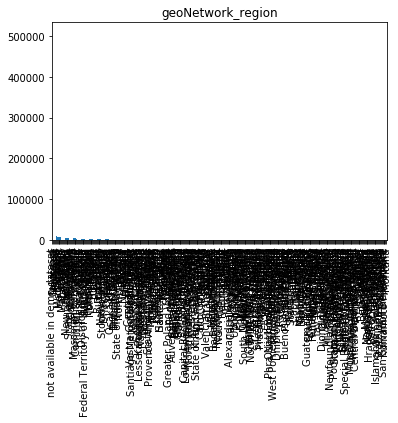

In [108]:
sample['geoNetwork_region'].value_counts().plot.bar(title='geoNetwork_region')

In [62]:
sample['geoNetwork_metro'].value_counts()

not available in demo dataset        508229
(not set)                            201766
San Francisco-Oakland-San Jose CA     95913
New York NY                           26917
London                                12571
                                      ...  
Springfield-Holyoke MA                    6
Tallahassee FL-Thomasville GA             6
Chattanooga TN                            6
Butte-Bozeman MT                          3
Boise ID                                  3
Name: geoNetwork_metro, Length: 94, dtype: int64

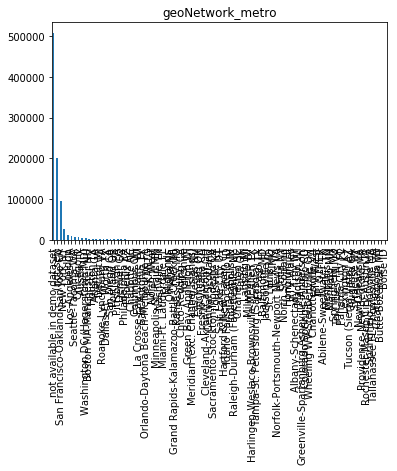

In [110]:
sample['geoNetwork_metro'].value_counts().plot.bar(title='geoNetwork_metro')

In [63]:
sample['geoNetwork_city'].value_counts()

not available in demo dataset    508229
Mountain View                     40884
(not set)                         34262
New York                          26371
San Francisco                     20329
                                  ...  
Kumamoto                              5
Campbell                              5
Daly City                             4
Boise                                 3
Bozeman                               3
Name: geoNetwork_city, Length: 649, dtype: int64

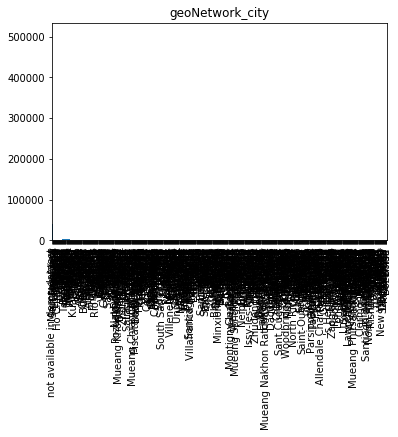

In [111]:
sample['geoNetwork_city'].value_counts().plot.bar(title='geoNetwork_city')

In [65]:
sample['geoNetwork_networkDomain'].value_counts()

(not set)          244881
unknown.unknown    146034
comcast.net         28743
rr.com              14827
verizon.net         13637
                    ...  
uninets.net             1
bioartmed.com           1
ceriluz.net.br          1
bogalnet.se             1
ilmenau.net             1
Name: geoNetwork_networkDomain, Length: 28064, dtype: int64

In [70]:
sample['totals_hits'].value_counts()

1      446754
2      137952
3       70402
4       42444
5       30939
        ...  
228         1
180         1
278         1
183         1
308         1
Name: totals_hits, Length: 274, dtype: int64

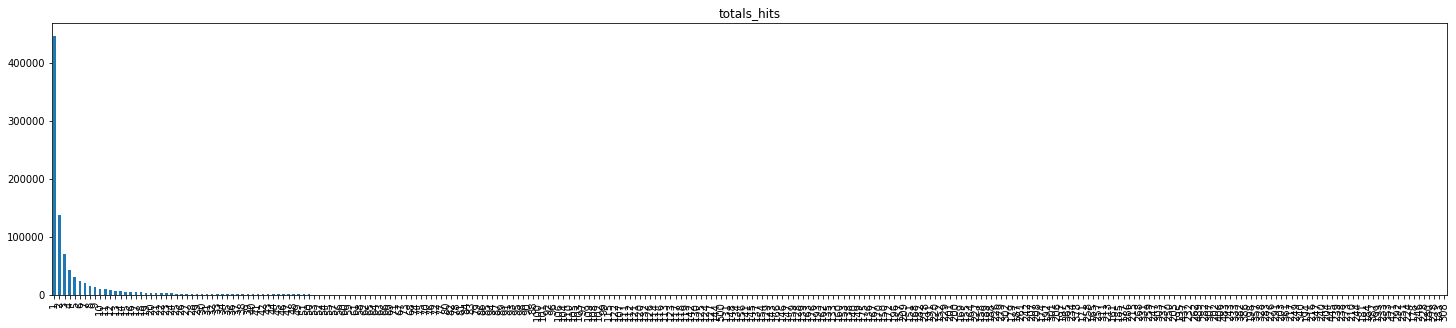

In [114]:
sample['totals_hits'].value_counts().plot.bar(title='totals_hits',figsize=(25,5))

In [71]:
sample['totals_pageviews'].value_counts()

1      452522
2      143770
3       73835
4       45192
5       33411
        ...  
223         1
233         1
190         1
358         1
162         1
Name: totals_pageviews, Length: 213, dtype: int64

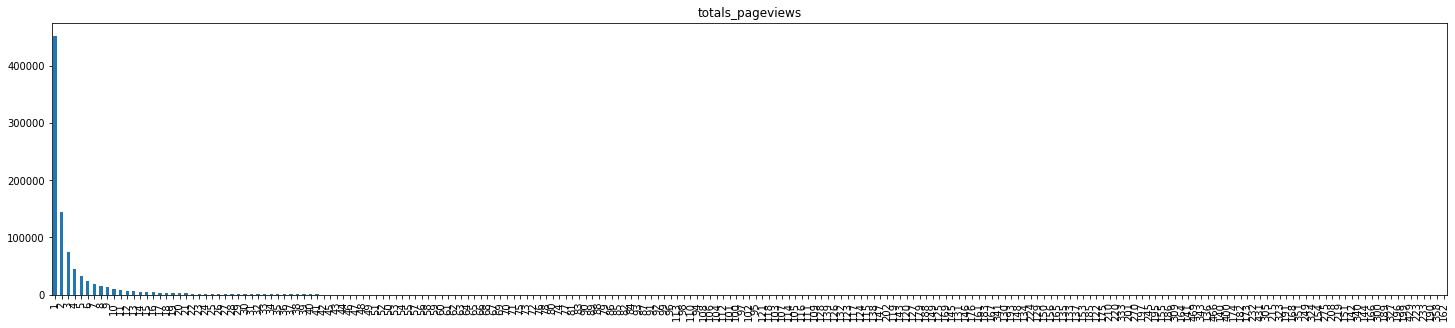

In [116]:
sample['totals_pageviews'].value_counts().plot.bar(title='totals_pageviews',figsize=(25,5))

In [72]:
sample['totals_bounces'].value_counts()

1    450630
Name: totals_bounces, dtype: int64

In [73]:
sample['totals_transactionRevenue'].value_counts()

16990000      256
18990000      189
33590000      187
44790000      170
13590000      135
             ... 
1534410000      1
1351090000      1
27360000        1
286420000       1
69600000        1
Name: totals_transactionRevenue, Length: 5332, dtype: int64

In [74]:
sample['trafficSource_campaign'].value_counts()

(not set)                                          865347
Data Share Promo                                    16403
AW - Dynamic Search Ads Whole Site                  14244
AW - Accessories                                     7070
test-liyuhz                                           392
AW - Electronics                                       96
Retail (DO NOT EDIT owners nophakun and tianyu)        50
AW - Apparel                                           46
All Products                                            4
Data Share                                              1
Name: trafficSource_campaign, dtype: int64

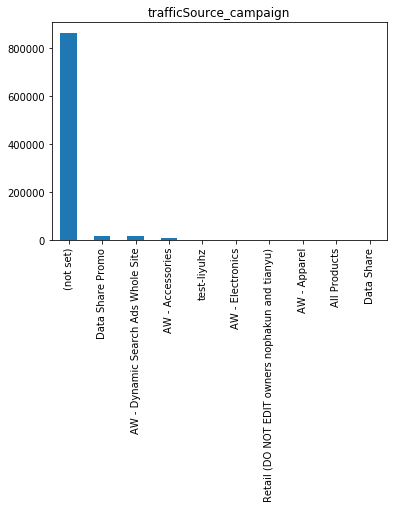

In [117]:
sample['trafficSource_campaign'].value_counts().plot.bar(title='trafficSource_campaign')

In [75]:
sample['trafficSource_source'].value_counts()

google                                               400788
youtube.com                                          212602
(direct)                                             143028
mall.googleplex.com                                   66416
Partners                                              16411
                                                      ...  
0.shared.bow.cat2.ads-bow.yw.borg.google.com:9862         1
yahoo.com                                                 1
start.wow.com                                             1
images.google.co.in                                       1
google.bg                                                 1
Name: trafficSource_source, Length: 380, dtype: int64

In [76]:
sample['trafficSource_medium'].value_counts()

organic      381561
referral     330955
(none)       143026
cpc           25326
affiliate     16403
cpm            6262
(not set)       120
Name: trafficSource_medium, dtype: int64

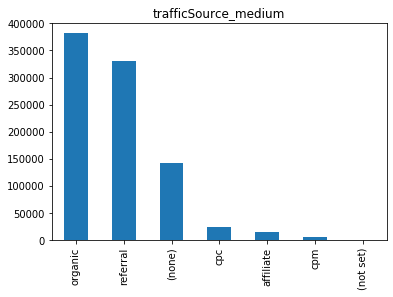

In [119]:
sample['trafficSource_medium'].value_counts().plot.bar(title='trafficSource_medium')

In [77]:
sample['trafficSource_keyword'].value_counts()

(not provided)                     366363
6qEhsCssdK0z36ri                    11503
(Remarketing/Content targeting)      2298
1hZbAqLCbjwfgOH7                     2264
google merchandise store             2209
                                    ...  
googlekids                              1
google tore                             1
google steckar                          1
stylus pen light                        1
gogle                                   1
Name: trafficSource_keyword, Length: 3659, dtype: int64

In [79]:
sample['trafficSource_isTrueDirect'].value_counts()

True    274005
Name: trafficSource_isTrueDirect, dtype: int64

In [80]:
sample['trafficSource_referralPath'].value_counts()

/                                                                                                                                                                                  75523
/yt/about/                                                                                                                                                                         71036
/analytics/web/                                                                                                                                                                    14620
/yt/about/tr/                                                                                                                                                                      14599
/yt/about/vi/                                                                                                                                                                      13753
                                                                           

In [81]:
sample['trafficSource_adwordsClickInfo.page'].value_counts()

1     21362
2        73
3        10
5         7
7         3
9         2
4         2
14        1
Name: trafficSource_adwordsClickInfo.page, dtype: int64

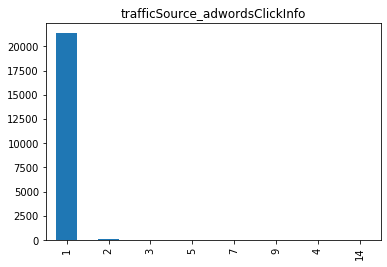

In [120]:
sample['trafficSource_adwordsClickInfo.page'].value_counts().plot.bar(title='trafficSource_adwordsClickInfo')

In [122]:
sample['trafficSource_adwordsClickInfo.slot'].value_counts()

Top    20956
RHS      504
Name: trafficSource_adwordsClickInfo.slot, dtype: int64

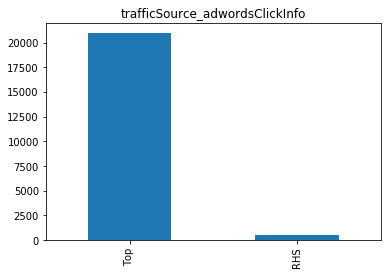

In [121]:
sample['trafficSource_adwordsClickInfo.slot'].value_counts().plot.bar(title='trafficSource_adwordsClickInfo')

In [83]:
sample['trafficSource_adwordsClickInfo.gclId'].value_counts()

Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3ZdwYO8GTsjiBFd5MPHStZa9y_9NCrI8X97oaAglc8P8HAQ    70
Cj0KEQjw1ee_BRD3hK6x993YzeoBEiQA5RH_BEA562M9tvl_mtnAFvtDnDqOQRp1RvxMMgwjcX1LAfwaAj4o8P8HAQ    41
CJH1vbf94M8CFUElgQodyakHgQ                                                                    29
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4LcssmB_RWgvpPnltzlzj5rGwqx5lk87wC5CjfcqzneNZewaAiAp8P8HAQ    27
CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBEJui6ggr6ocA-eDC2-lX7W1m5IA1c_qNbzwZVTqUanxoCb5rw_wcB      24
                                                                                              ..
CNfyiba_ltICFQVbfgodDNYAxg                                                                     1
COe98ZOUp9QCFQOtaQodzwIE5g                                                                     1
EAIaIQobChMIvZGthpS31AIVEI5-Ch032QEBEAAYASAAEgKw1PD_BwE                                        1
CMLF8aeV79ICFcsbgQodvWQGRg                                                                     1
CNSy2_CbrtMCFVWHswodEhMDig    

In [84]:
sample['trafficSource_adwordsClickInfo.adNetworkType'].value_counts()

Google Search      21453
Search partners        7
Name: trafficSource_adwordsClickInfo.adNetworkType, dtype: int64

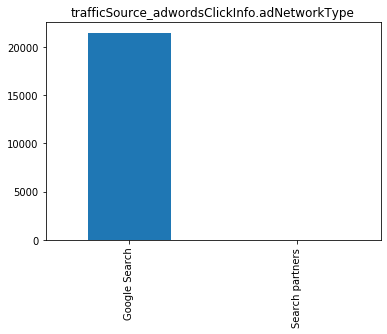

In [123]:
sample['trafficSource_adwordsClickInfo.adNetworkType'].value_counts().plot.bar(title='trafficSource_adwordsClickInfo.adNetworkType')

In [85]:
sample['trafficSource_adwordsClickInfo.isVideoAd'].value_counts()

False    21460
Name: trafficSource_adwordsClickInfo.isVideoAd, dtype: int64

In [86]:
sample['trafficSource_adContent'].value_counts()

Google Merchandise Collection                  5122
Google Online Store                            1245
Display Ad created 3/11/14                      967
Full auto ad IMAGE ONLY                         822
Ad from 12/13/16                                610
Ad from 11/3/16                                 489
Display Ad created 3/11/15                      392
{KeyWord:Google Brand Items}                    251
{KeyWord:Google Merchandise}                    155
Ad from 11/7/16                                 123
First Full Auto Template Test Ad                 87
Google Merchandise                               87
20% discount                                     75
{KeyWord:Google Branded Gear}                    67
{KeyWord:Looking for Google Bags?}               65
Swag with Google Logos                           64
Display Ad created 11/17/14                      50
{KeyWord:Want Google Stickers?}                  42
JD_5a_v1                                         41
{KeyWord:Goo

In [87]:
sample['trafficSource_campaignCode'].value_counts()

11251kjhkvahf    1
Name: trafficSource_campaignCode, dtype: int64

#### columns have all identical values:
1) visitId is identical to visitStartTime <br>
2) sessionId is fullVisitorId _ visitId ( fullVisitorId is one user id)<br>
3) 'device_isMobile' is almost the same with 'device_deviceCategory'

In [88]:
sample['socialEngagementType'].value_counts()
sample['device_browserSize'].value_counts() #all values are same
sample['device_operatingSystemVersion'].value_counts() #all values are same
sample['device_mobileDeviceBranding'].value_counts()
sample['device_mobileDeviceModel'].value_counts()
sample['device_mobileInputSelector'].value_counts()
sample['device_mobileDeviceInfo'].value_counts()
sample['device_mobileDeviceMarketingName'].value_counts()
sample['device_flashVersion'].value_counts()
sample['device_language'].value_counts()
sample['device_screenColors'].value_counts()
sample['device_screenResolution'].value_counts()
sample['geoNetwork_cityId'].value_counts()
sample['geoNetwork_latitude'].value_counts()
sample['geoNetwork_longitude'].value_counts()
sample['geoNetwork_networkLocation'].value_counts()
sample['totals_visits'].value_counts()
sample['trafficSource_adwordsClickInfo.criteriaParameters'].value_counts()

not available in demo dataset    903653
Name: trafficSource_adwordsClickInfo.criteriaParameters, dtype: int64

In [89]:
identical_cols = [
    'socialEngagementType',
    
    'device_browserSize',
    'device_operatingSystemVersion',
    'device_mobileDeviceBranding',
    'device_mobileDeviceModel',
    'device_mobileInputSelector',
    'device_mobileDeviceInfo',
    'device_mobileDeviceMarketingName',
    'device_flashVersion',
    'device_language',
    'device_screenColors',
    'device_screenResolution',
    
    'geoNetwork_cityId',
    'geoNetwork_latitude',
    'geoNetwork_longitude',
    'geoNetwork_networkLocation',
    
    'totals_visits',
    
    'trafficSource_adwordsClickInfo.criteriaParameters'
    
]

In [90]:
len(identical_cols)

18

-------------- end of understanding data features -----------------

#### Check missing values
-- features with missing values should be fixed: <br>
1) 'totals_transactionRevenue' is the target value, missing value means 0 transaction <br>
2) 'trafficSource_adwordsClickInfo.isVideoAd' missing value should be filled with 'True' <br>
3) 'trafficSource_isTrueDirect' missing value should be filled with 'False' <br>
4) 'trafficSource_keyword' not sure, probably filled with '(not provided)' <br> 
5) 'totals_pageviews' missing values should filled with mode '1'
<br>
6) 'totals_bounces' only has one value '1', not sure, and not sure what does it mean <br>
7) 'totals_newVisits' only has one value '1', not sure, and not sure what does it mean <br>


<br>
-- meaningless features with missing values: <br>
1) 'trafficSource_adContent' should drop <br>
2) 'trafficSource_adwordsClickInfo.adNetworkType' should drop <br>
3) 'trafficSource_adwordsClickInfo.slot' should drop <br>
4) 'trafficSource_adwordsClickInfo.page' should drop <br>
5) 'trafficSource_adwordsClickInfo.gclId' should drop <br>
6) 'trafficSource_referralPath' should drop <br>
7) 'trafficSource_campaignCode' should drop

In [36]:
df_missing = sample.isna().sum()[sample.isna().sum()/len(sample)>0]
df_missing=df_missing.sort_values(ascending=False)
df_missing

trafficSource_campaignCode                      903652
trafficSource_adContent                         892707
totals_transactionRevenue                       892138
trafficSource_adwordsClickInfo.isVideoAd        882193
trafficSource_adwordsClickInfo.adNetworkType    882193
trafficSource_adwordsClickInfo.slot             882193
trafficSource_adwordsClickInfo.page             882193
trafficSource_adwordsClickInfo.gclId            882092
trafficSource_isTrueDirect                      629648
trafficSource_referralPath                      572712
trafficSource_keyword                           502929
totals_bounces                                  453023
totals_newVisits                                200593
totals_pageviews                                   100
dtype: int64

In [37]:
df_missing/len(sample)

trafficSource_campaignCode                      0.999999
trafficSource_adContent                         0.987887
totals_transactionRevenue                       0.987257
trafficSource_adwordsClickInfo.isVideoAd        0.976252
trafficSource_adwordsClickInfo.adNetworkType    0.976252
trafficSource_adwordsClickInfo.slot             0.976252
trafficSource_adwordsClickInfo.page             0.976252
trafficSource_adwordsClickInfo.gclId            0.976140
trafficSource_isTrueDirect                      0.696781
trafficSource_referralPath                      0.633774
trafficSource_keyword                           0.556551
totals_bounces                                  0.501324
totals_newVisits                                0.221980
totals_pageviews                                0.000111
dtype: float64

drop columns:<br>
1) meaningless features with missing values<br>
2) identical features<br>

In [143]:
# drop missing values > 5% columns
meanless_cols = [
    'trafficSource_adContent',
    'trafficSource_adwordsClickInfo.adNetworkType',
    'trafficSource_adwordsClickInfo.slot',
    'trafficSource_adwordsClickInfo.page',
    'trafficSource_adwordsClickInfo.gclId',
    'trafficSource_referralPath',
    'trafficSource_campaignCode',
]
identical_cols = [
    'socialEngagementType',
    
    'device_browserSize',
    'device_operatingSystemVersion',
    'device_mobileDeviceBranding',
    'device_mobileDeviceModel',
    'device_mobileInputSelector',
    'device_mobileDeviceInfo',
    'device_mobileDeviceMarketingName',
    'device_flashVersion',
    'device_language',
    'device_screenColors',
    'device_screenResolution',
    
    'geoNetwork_cityId',
    'geoNetwork_latitude',
    'geoNetwork_longitude',
    'geoNetwork_networkLocation',
    
    'totals_visits',
    
    'trafficSource_adwordsClickInfo.criteriaParameters'
]

drop_columns = meanless_cols + identical_cols
                                        


In [144]:
print('meaningless features with missing values :',len(meanless_cols))
print('features with identical values :',len(identical_cols))
print('total features dropped', len(drop_columns))

meaningless features with missing values : 7
features with identical values : 18
total features dropped 25


In [ ]:
clean_df1 = sample.drop(drop_columns,axis=1)

drop 25 features, ( 54 --> 29 cols)<br>
<br>
fill missing values

In [15]:
clean_df1.shape

(903653, 41)

In [146]:
values = {
          'totals_transactionRevenue' : 0,
         'trafficSource_adwordsClickInfo.isVideoAd' : True,
          'trafficSource_isTrueDirect' : False,
          'trafficSource_keyword' : '(not provided)',
        'totals_pageviews' : 1, 
         }
clean_df2 = clean_df1.fillna(value=values)

In [19]:
clean_df2.isna().sum()

channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
socialEngagementType                                 0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device_browser                                       0
device_browserVersion                                0
device_browserSize                                   0
device_operatingSystem                               0
device_operatingSystemVersion                        0
device_isMobile                                      0
device_mobileDeviceBranding                          0
device_mobileDeviceModel                             0
device_mobileInputSelector                           0
device_mobileDeviceInfo                              0
device_mobileDeviceMarketingName                     0
device_fla

In [20]:
clean_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 41 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   socialEngagementType                               903653 non-null  object
 4   visitId                                            903653 non-null  int64 
 5   visitNumber                                        903653 non-null  int64 
 6   visitStartTime                                     903653 non-null  int64 
 7   device_browser                                     903653 non-null  object
 8   device_browserVersion                              903653 non-null  object
 9   devi

In [ ]:
clean_df2